<a href="https://www.kaggle.com/code/ramirazodi/titanic-flex-vote-pipe?scriptVersionId=157950152" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Highly Flexible and Nested Ensemble Pipelines Leading into a Voting Regressor & All Steps & Parameters Optimized through GridSearchCV

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import sklearn
import matplotlib
import warnings
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures 
from sklearn.preprocessing import PowerTransformer, SplineTransformer, KBinsDiscretizer, FunctionTransformer, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, f_regression, f_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from IPython.display import display, HTML
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

In [2]:
# Utilize set_output API of scikit to maintain padnas dataframe capabiity throughout the pipelines
set_config(display='diagram', transform_output="pandas")

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_raw = pd.read_csv('/kaggle/input/titanic/train.csv')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Quick EDA

In [4]:
# Mapping dictionary to make exctracted titles consistent
title_map = {
    "Master": "Master", "Mr": "Mr",
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Dr": "Professional", "Rev": "Professional",
    "Major": "Military", "Col": "Military", "Capt": "Military",
    "Jonkheer": "Nobility", "Don": "Nobility", "Sir": "Nobility", "Lady": "Nobility", "Countess": "Nobility"
}

# Ticket prefix mapping to handle complex variations
ticketprefix_mapping = {
    'STONO': 'STON/O', 'STONO': 'STON/O', 'STONO2': 'STON/O',
    'SOTONOQ': 'SOTON/OQ' ,'SOTONOQ': 'SOTON/OQ','SOTON/O.Q': 'SOTON/O','SOTON/OQ': 'SOTON/O',
    'SCPARIS': 'SC/PARIS','SCPARIS': 'SC/PARIS', 'SC/PARIS': 'SC/PARIS', 'S.C./PARIS': 'SC/PARIS',
    'C.A.': 'CA', 'C.A': 'CA', 'CA.': 'CA',
    'SCAH': 'SC/AH',
    'W./C': 'W/C', 'W.C': 'W/C',
    'S.W./PP' : 'SW/PP',
    'W.E.P': 'WE/P',
    'S.O./P.P': 'SO/PP', 'S.O.P': 'SO/PP',
    'P/PP': 'PP',
    #'WE/P': 'W/C',
    #'W.E.P': 'W/C',
    #'S.O.C': 'SO/C',
    #'SC/AH': 'SC/PARIS',
}


# Define Age imputation function
def age_impute(df):
    
    age_means = df.groupby(['Title', 'TicketGroupSize', 'Parch', 'SibSp'])['Age'].transform('mean')

    if age_means.isnull().any():
        age_means = age_means.fillna(df.groupby(['Title', 'TicketGroupSize'])['Age'].transform('mean'))
        
    if age_means.isnull().any():
        age_means = age_means.fillna(df.groupby(['Title'])['Age'].transform('mean'))
    
    # Fallback
    overall_mean = df['Age'].mean()
        
    df['Age_mean'] = df['Age'].fillna(age_means).fillna(overall_mean)
    
    return df

# Define function that uses Catboost to impute Age column. The Catboost model in this function has already been hyper-parameter optimized on this dataset
def cb_age_impute(df, target='Age', features=['Pclass', 'SibSp', 'Parch', 'Title', 'Sex']):

    df['Age_cb'] = df[target]
    
    # Splitting the data into training and test sets based on original 'Age'
    df_train = df.dropna(subset=[target])
    df_test = df[df[target].isnull()]
    
    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]

    # Define and fit the model
    cb_model = CatBoostRegressor(iterations=100,
                                 learning_rate=0.05,
                                 depth=6,
                                 cat_features=['Title', 'Sex'],
                                 loss_function='MAE',
                                 random_seed=42,  
                                 verbose=False)

    cb_model.fit(X_train, y_train)
    
    # Predict 'Age' for the test data
    predicted_ages = cb_model.predict(X_test)

    # Replace the NaNs in 'Age_cb' with the predictions
    df.loc[df[target].isnull(), 'Age_cb'] = predicted_ages

    return df



# Define TicketPrefix sparcity reducer.The function groups together TicketPrefix values that have less than cutoff number of observation  
def group_rare_prefixes(df, column='TicketPrefix', cutoff=5):
    
    prefixes_to_group = df[column].value_counts()
    rare_prefixes = prefixes_to_group[prefixes_to_group < cutoff].index
    
    # Create a mask where True corresponds to values to be grouped into "OTHER"
    is_rare = df[column].isin(rare_prefixes)
    
    # Use the mask to assign "OTHER" to the rare values
    df[column] = df[column].where(~is_rare, other="OTHER")
    return df


def deck_impute(df, level=7):
    # Capture original missing Deck values
    original_missing_deck = df['Deck'].isnull().astype(int)

    # Create mode mappings for Deck based on different groupings, now including 'Embarked' and 'Pclass'
    modes = {
        1: df.groupby(['LastName', 'Ticket', 'Embarked', 'Pclass', 'GroupSize', 'LastNameRepeat'])['Deck'],
        2: df.groupby(['LastName', 'TicketPrefix', 'Embarked', 'Pclass', 'GroupSize', 'LastNameRepeat'])['Deck'],
        3: df.groupby(['LastName', 'Embarked', 'Pclass', 'GroupSize', 'LastNameRepeat'])['Deck'],
        4: df.groupby(['TicketPrefix', 'Title', 'FareQcut', 'Embarked', 'Pclass', 'GroupSize', 'LastNameRepeat'])['Deck'],
        5: df.groupby(['FareQcut', 'Title', 'Embarked', 'Pclass', 'GroupSize', 'LastNameRepeat'])['Deck'],
        6: df.groupby(['FareQcut', 'Title', 'Pclass', 'LastNameRepeat'])['Deck'],
        7: df.groupby(['FareQcut', 'Title'])['Deck'],
    }

    df_imputed = df.copy()

    # Loop through the modes and merge them if they're at or below the specified level
    for i in range(1, level+1):
        mode_mapping = modes[i].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan).rename(f'DeckMode{i}')
        keys = modes[i].grouper.names  # extract grouping columns for the merge
        df_imputed = df_imputed.merge(mode_mapping, left_on=keys, right_index=True, how='left')

    # Assign Deck values conditionally based on level and drop temporary DeckMode columns
    for i in range(1, level+1):
        df_imputed = df_imputed.assign(Deck=lambda df_: np.where(df_['Deck'].isnull(), df_[f'DeckMode{i}'], df_['Deck']))
        df_imputed = df_imputed.drop(columns=f'DeckMode{i}')

    # Final assignment for Deck and Deck_Missing
    df_imputed = df_imputed.assign(
        Deck=lambda df_: df_['Deck'].fillna('Unknown'),
        Deck_Missing=original_missing_deck
    )

    return df_imputed

In [5]:
# Create copy of raw data for EDA purposes to avoid contamination 
df_eda = (df_raw
          .copy()
          .assign(
              GroupSize=lambda df_: df_.SibSp.add(df_.Parch),
              Deck=lambda df_: df_.Cabin.str.extract('([A-Za-z])', expand=False),
              NumCabins=lambda df_: df_.Cabin.str.count(' ').add(1),
              FirstCabNum=lambda df_: df_.Cabin.str.extract('(\d+)', expand=False),
              TicketPrefix=lambda df_: df_.Ticket.str.extract('([A-Za-z./]*[A-Za-z])', expand=False).str.replace('\.', '').str.upper(),
              TicketNum=lambda df_: df_.Ticket.str.extract('(\d+)$'),
              TicketGroupSize=lambda df_: df_.Ticket.map(df_.Ticket.value_counts()).astype(int),
              TicketNumDigits=lambda df_: df_.TicketNum.str.len(),
              Title=lambda df_: df_.Name.str.extract(' ([A-Za-z]+)\.', expand=False),
              LastName=lambda df_: df_.Name.str.extract('^([^,]+),', expand=False),
              LastNameRepeat=lambda df_: df_.LastName.map(df_.LastName.value_counts()).astype(int),
              FareQcut=lambda df_: pd.qcut(df_.Fare, q=10, labels=[bin_label for bin_label in range(1, 11)]).astype(int),
          )
          .assign(
              Title=lambda df_: df_.Title.map(title_map).fillna(df_.Title),
              TicketPrefix=lambda df_: df_.TicketPrefix.map(ticketprefix_mapping).fillna(df_.TicketPrefix).fillna('No_Prefix'),
              NumCabins=lambda df_: df_.NumCabins.fillna(df_.NumCabins.mode()[0]),
              TicketNumDigits=lambda df_: df_.TicketNumDigits.fillna(df_.TicketNumDigits.fillna(0)).astype(int),
              TicketNum=lambda df_: df_.TicketNum.fillna(0).astype(int),
              Embarked=lambda df_: df_.Embarked.fillna(df_.Embarked.mode()[0])
          )
          .pipe(group_rare_prefixes, column='TicketPrefix', cutoff=5)
          .pipe(cb_age_impute, target='Age', features=['Pclass', 'SibSp', 'Parch', 'Title', 'Sex'])
          .pipe(deck_impute, level=5)
          .drop(columns=['Name', 'Cabin', 'Ticket', 'FirstCabNum'])
          .assign(
              Sex_fctr=lambda df_: pd.factorize(df_.Sex)[0],
              Embarked_fctr=lambda df_: pd.factorize(df_.Embarked)[0],
              Deck_fctr=lambda df_: pd.factorize(df_.Deck)[0],
              TicketPrefix_fctr=lambda df_: pd.factorize(df_.TicketPrefix)[0],
              Title_fctr=lambda df_: pd.factorize(df_.Title)[0],
          )
         )

display(df_raw.columns)
display(df_eda.shape)
display(df_eda.info())
display(df_eda.describe().round(1))
display(df_eda.tail(50))

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

(891, 27)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Sex                891 non-null    object 
 4   Age                714 non-null    float64
 5   SibSp              891 non-null    int64  
 6   Parch              891 non-null    int64  
 7   Fare               891 non-null    float64
 8   Embarked           891 non-null    object 
 9   GroupSize          891 non-null    int64  
 10  Deck               891 non-null    object 
 11  NumCabins          891 non-null    float64
 12  TicketPrefix       891 non-null    object 
 13  TicketNum          891 non-null    int64  
 14  TicketGroupSize    891 non-null    int64  
 15  TicketNumDigits    891 non-null    int64  
 16  Title              891 non

None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,GroupSize,NumCabins,TicketNum,...,TicketNumDigits,LastNameRepeat,FareQcut,Age_cb,Deck_Missing,Sex_fctr,Embarked_fctr,Deck_fctr,TicketPrefix_fctr,Title_fctr
count,891.0,891.0,891.0,714.0,891.0,891.0,891.0,891.0,891.0,891.0,...,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0
mean,446.0,0.4,2.3,29.7,0.5,0.4,32.2,0.9,1.0,296989.1,...,5.3,1.9,5.5,29.2,0.8,0.4,0.4,1.5,3.3,0.8
std,257.4,0.5,0.8,14.5,1.1,0.8,49.7,1.6,0.3,656438.3,...,1.0,1.5,2.9,13.6,0.4,0.5,0.6,2.2,1.9,1.2
min,1.0,0.0,1.0,0.4,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
25%,223.5,0.0,2.0,20.1,0.0,0.0,7.9,0.0,1.0,14312.5,...,5.0,1.0,3.0,21.0,1.0,0.0,0.0,0.0,3.0,0.0
50%,446.0,0.0,3.0,28.0,0.0,0.0,14.5,0.0,1.0,112058.0,...,6.0,1.0,5.0,26.8,1.0,0.0,0.0,0.0,3.0,0.0
75%,668.5,1.0,3.0,38.0,1.0,0.0,31.0,1.0,1.0,347082.0,...,6.0,2.0,8.0,36.8,1.0,1.0,1.0,2.0,3.0,2.0
max,891.0,1.0,3.0,80.0,8.0,6.0,512.3,10.0,4.0,3101317.0,...,7.0,9.0,10.0,80.0,1.0,1.0,2.0,8.0,12.0,6.0


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,GroupSize,...,LastName,LastNameRepeat,FareQcut,Age_cb,Deck_Missing,Sex_fctr,Embarked_fctr,Deck_fctr,TicketPrefix_fctr,Title_fctr
841,842,0,2,male,16.0,0,0,10.5000,S,0,...,Mudd,1,4,16.000000,1,0,0,0,7,0
842,843,1,1,female,30.0,0,0,31.0000,C,0,...,Serepeca,1,8,30.000000,1,1,1,1,3,2
843,844,0,3,male,34.5,0,0,6.4375,C,0,...,Lemberopolous,1,1,34.500000,1,0,1,0,3,0
844,845,0,3,male,17.0,0,0,8.6625,S,0,...,Culumovic,1,4,17.000000,1,0,0,0,3,0
845,846,0,3,male,42.0,0,0,7.5500,S,0,...,Abbing,1,1,42.000000,1,0,0,0,5,0
846,847,0,3,male,NaN,8,2,69.5500,S,10,...,Sage,7,9,15.100032,1,0,0,0,5,0
847,848,0,3,male,35.0,0,0,7.8958,C,0,...,Markoff,1,3,35.000000,1,0,1,0,3,0
848,849,0,2,male,28.0,0,1,33.0000,S,1,...,Harper,4,8,28.000000,1,0,0,0,3,5
849,850,1,1,female,NaN,1,0,89.1042,C,1,...,Goldenberg,2,10,38.501707,0,1,1,1,3,1
850,851,0,3,male,4.0,4,2,31.2750,S,6,...,Andersson,9,8,4.000000,1,0,0,0,3,3


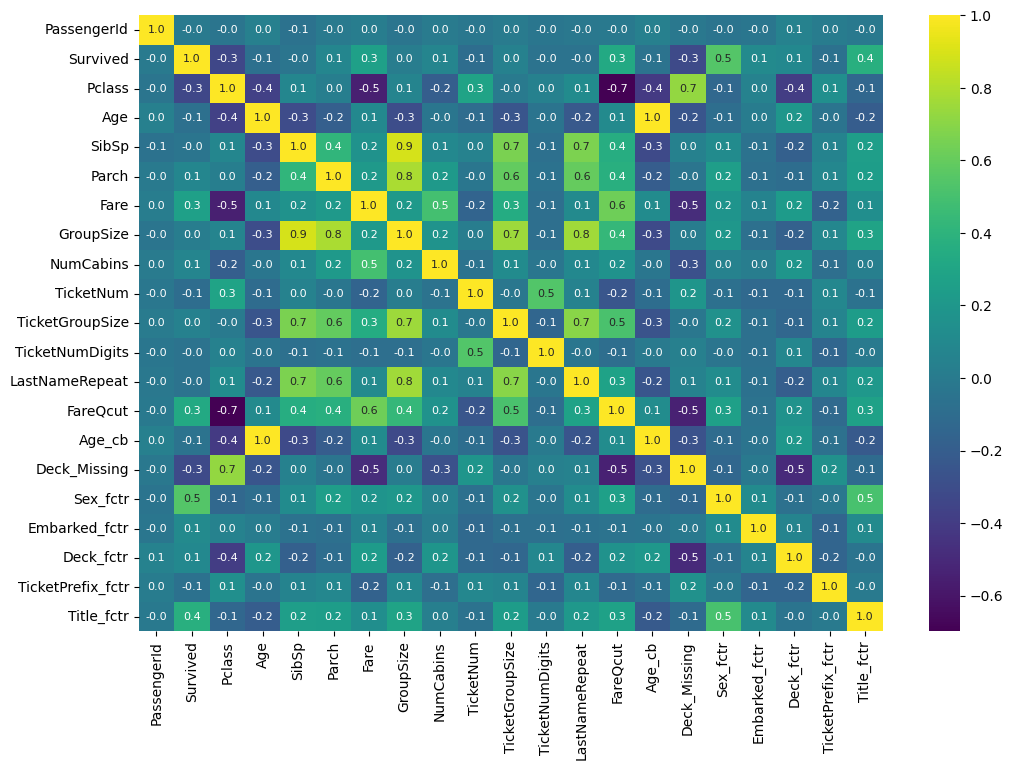

In [6]:
# Correlation Matrix
plt.figure(figsize=(12, 8)) 

cmap = sns.cubehelix_palette(start=0.55, rot=-.8, dark=-.0, light=.7, reverse=False, as_cmap=True)

# Generate a heatmap
sns.heatmap(
    data = df_eda.select_dtypes(include=[np.number]).corr(),
    annot=True,          
    fmt=".1f",          
    cmap='viridis',  
    annot_kws={"size": 8} 
)

plt.show()

# Visualization of EDA

Displaying: Fare_Sex_Survived


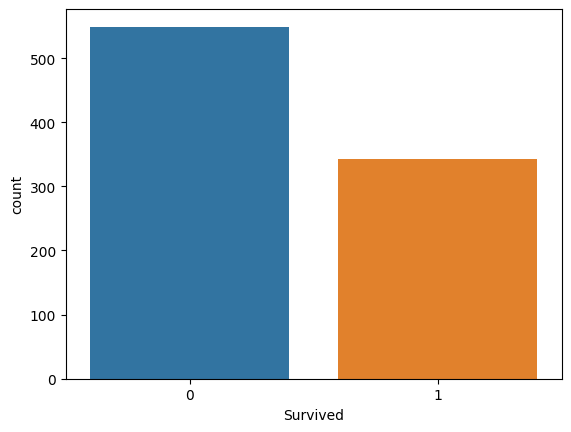

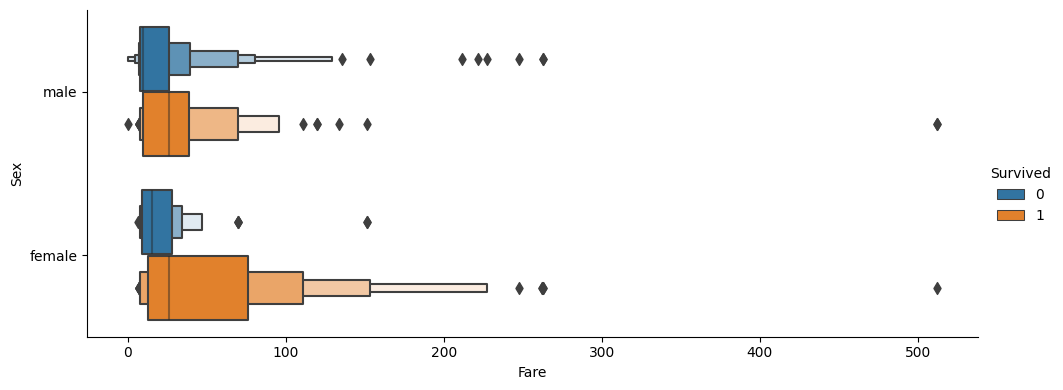

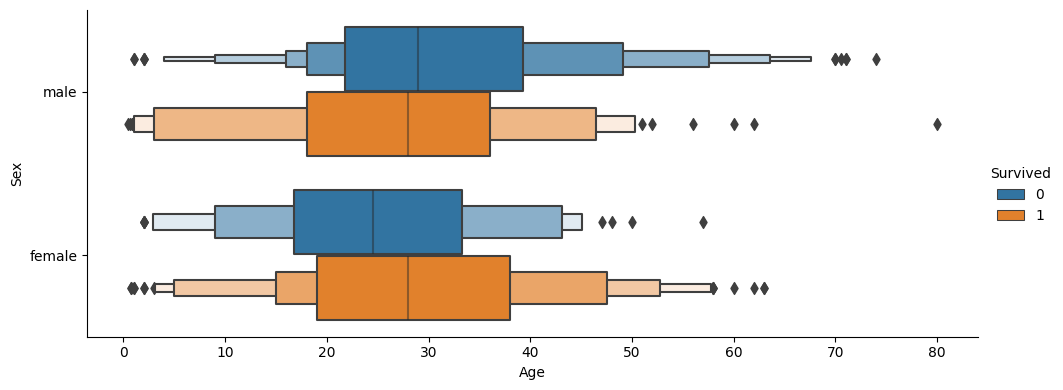

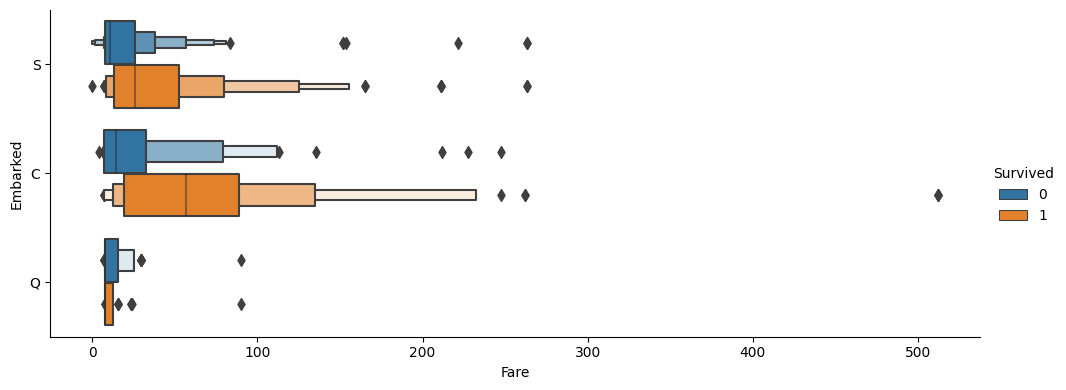

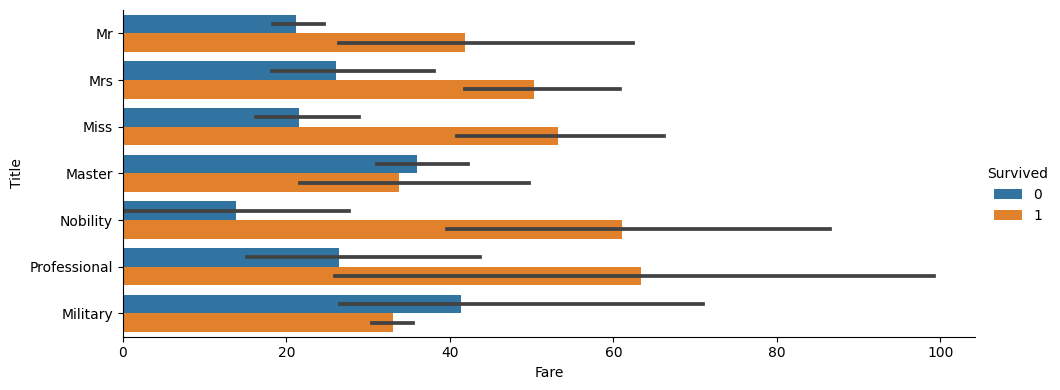

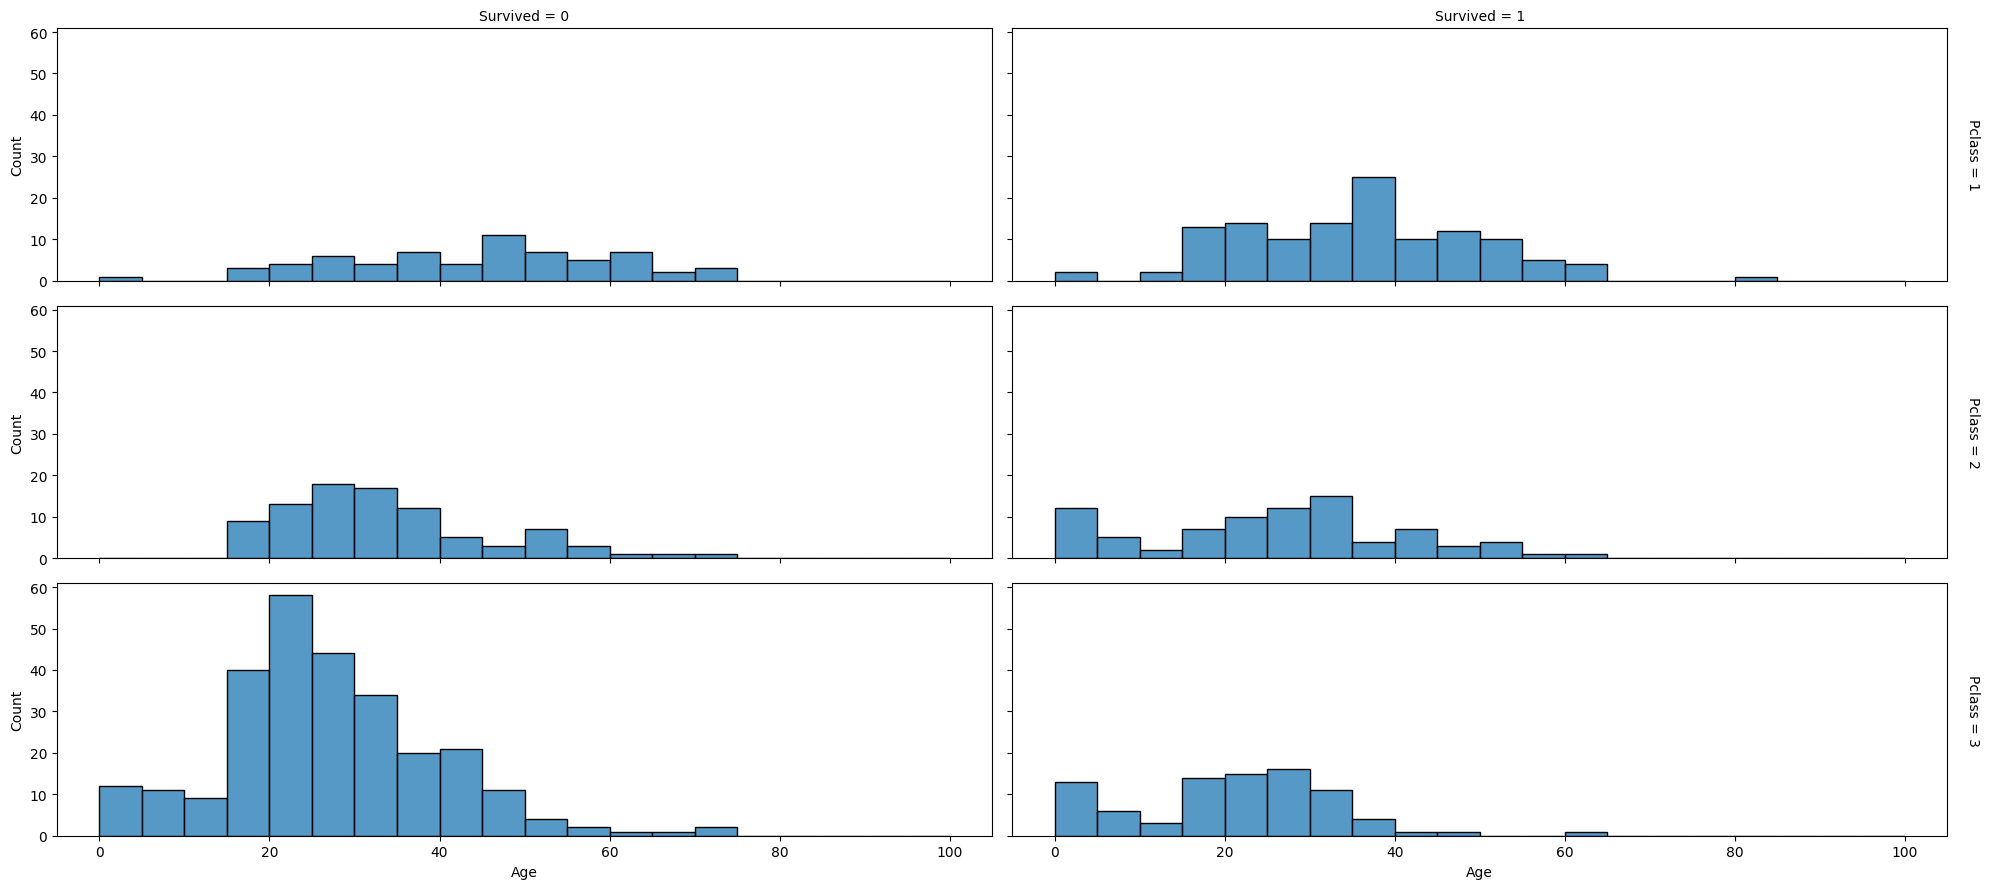

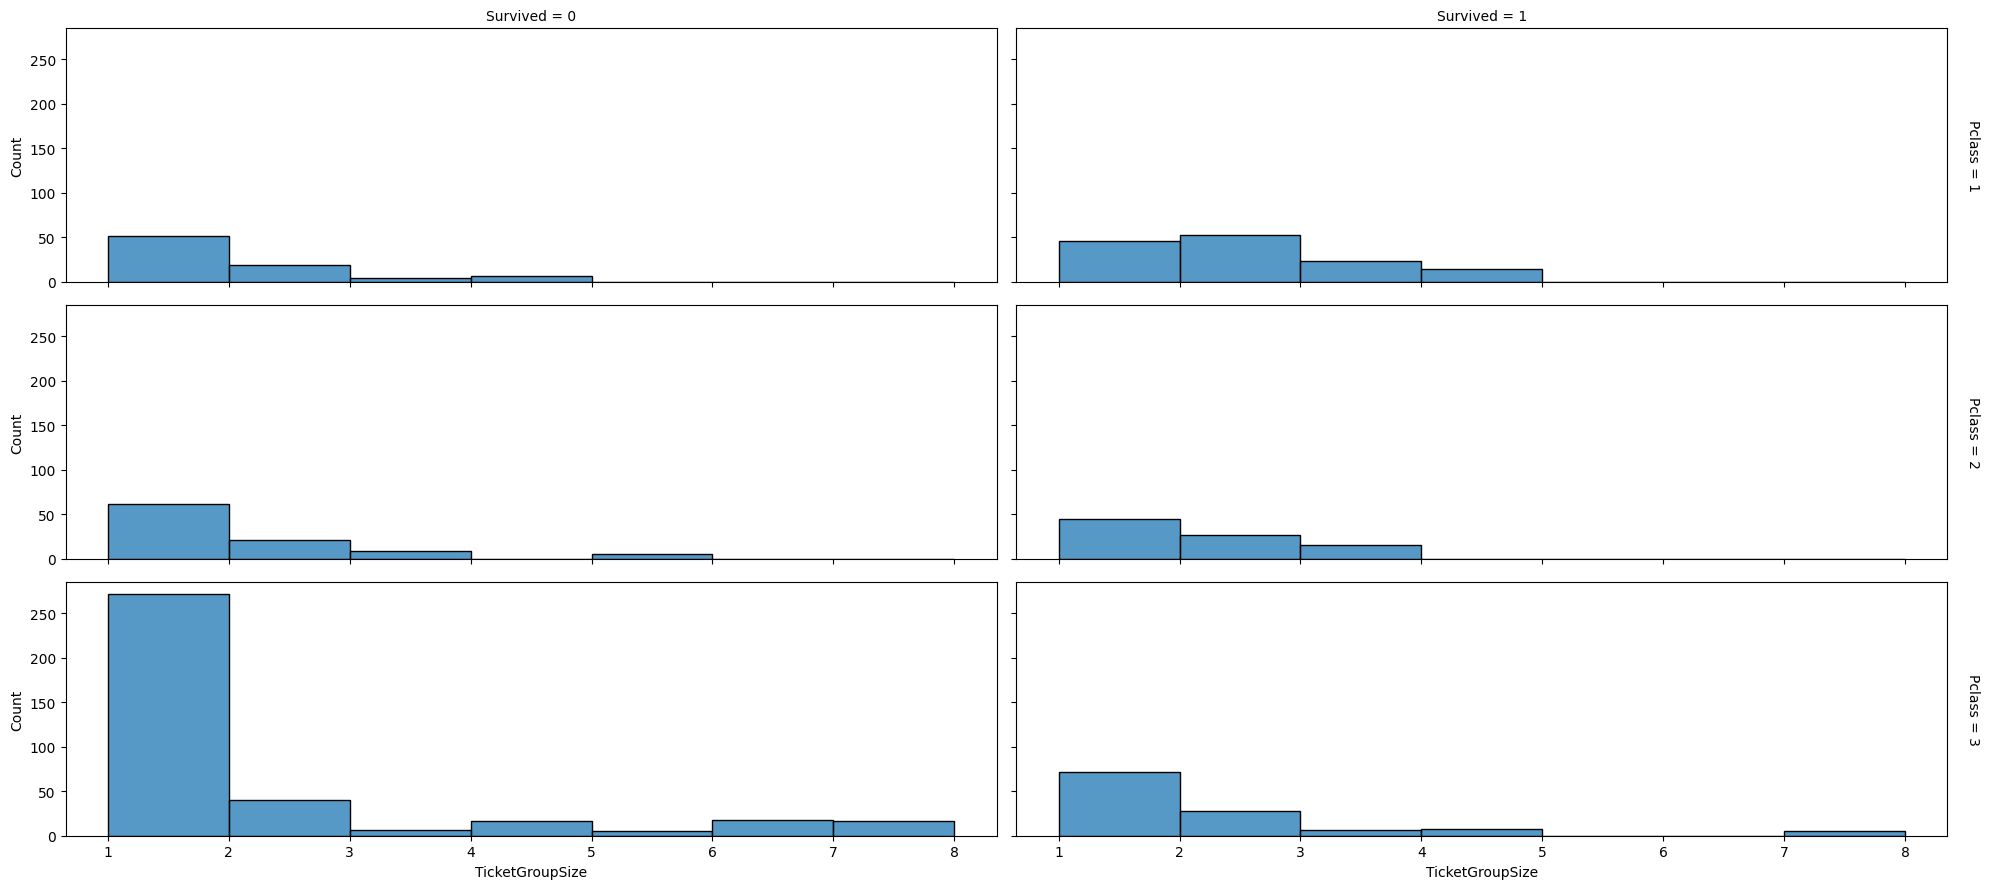

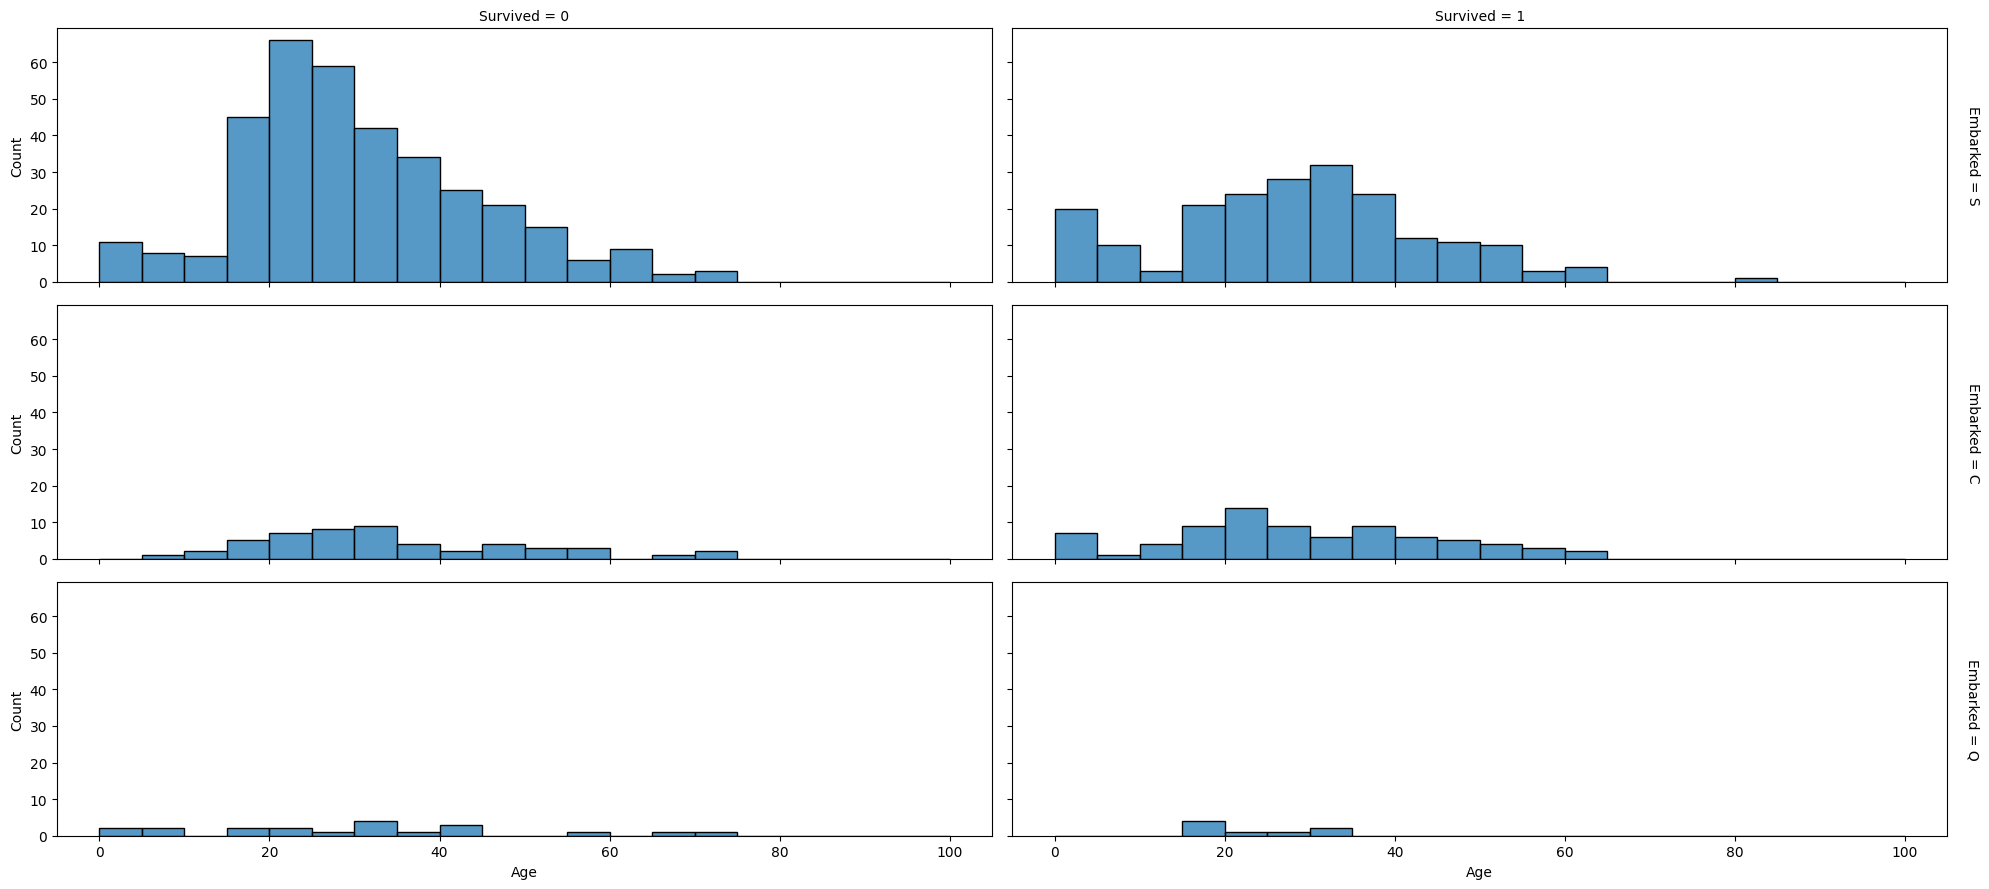

<Figure size 640x480 with 0 Axes>

Displaying: Age_Sex_Survived


<Figure size 640x480 with 0 Axes>

Displaying: Fare_Embarked_Survived


<Figure size 640x480 with 0 Axes>

Displaying: Fare_Title_Survived_Bar


<Figure size 640x480 with 0 Axes>

Displaying: Age_Pclass_Survived_Hist


<Figure size 640x480 with 0 Axes>

Displaying: TicketGroupSize_Pclass_Survived_Hist


<Figure size 640x480 with 0 Axes>

Displaying: Age_Embarked_Survived_Hist


<Figure size 640x480 with 0 Axes>

Displaying: Pclass_Deck_Count


<Figure size 640x480 with 0 Axes>

<Axes: xlabel='Pclass', ylabel='count'>

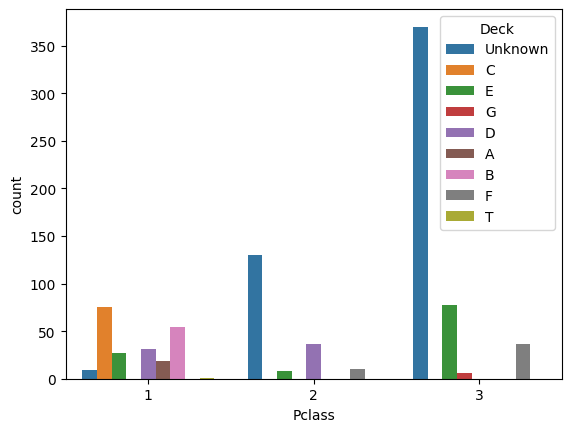

In [7]:
sns.countplot(data=df_eda, x="Survived")

# Customize these variables to adjust the appearance of all plots
height = 4
aspect = 2.5
palette = 'viridis'
binwidth_age = 5
binwidth_group = 1
age_range = (0, 100)
group_range = (1, 8)

# Define the size for the FacetGrid plots to match catplots
fg_height = height * 0.75
fg_width = height * aspect 
fg_asp_adj = 0.75

# Define a dictionary of plots for easy management
plots = {
    'Fare_Sex_Survived': sns.catplot(
        data=df_eda, x="Fare", y="Sex", hue='Survived', kind="boxen",
        height=height, aspect=aspect),

    'Age_Sex_Survived': sns.catplot(
        data=df_eda, x="Age", y="Sex", hue='Survived', kind="boxen",
        height=height, aspect=aspect),

    'Fare_Embarked_Survived': sns.catplot(
        data=df_eda, x="Fare", y="Embarked", hue='Survived', kind="boxen",
        height=height, aspect=aspect),

    'Fare_Title_Survived_Bar': sns.catplot(
        data=df_eda, x="Fare", y="Title", hue='Survived', kind="bar", estimator='mean',
        height=height, aspect=aspect),

    'Age_Pclass_Survived_Hist': sns.FacetGrid(
        df_eda, col="Survived",  row="Pclass", palette=palette,
        height=fg_height, aspect=aspect / fg_asp_adj, margin_titles=True, despine=False
    ).map_dataframe(sns.histplot, x="Age", binwidth=binwidth_age, binrange=age_range),

    'TicketGroupSize_Pclass_Survived_Hist': sns.FacetGrid(
        df_eda, col="Survived",  row="Pclass", palette=palette,
        height=fg_height, aspect=aspect / fg_asp_adj, margin_titles=True, despine=False
    ).map_dataframe(sns.histplot, x="TicketGroupSize", binwidth=binwidth_group, binrange=group_range),

    'Age_Embarked_Survived_Hist': sns.FacetGrid(
        df_eda, col="Survived",  row="Embarked", palette=palette,
        height=fg_height, aspect=aspect / fg_asp_adj, margin_titles=True, despine=False
    ).map_dataframe(sns.histplot, x="Age", binwidth=binwidth_age, binrange=age_range),

    # This plot is explicitly separated to avoid overlap
    'Pclass_Deck_Count': {
        'type': 'countplot',
        'data': df_eda,
        'x': "Pclass",
        'hue': "Deck"
    }
}


# Display all plots
for plot_name, plot_obj in plots.items():
    plt.figure()  # This ensures each plot is on a separate figure
    print(f"Displaying: {plot_name}")
    plot_obj
    plt.show()

sns.countplot(data=df_eda, x="Pclass", hue="Deck")

<Axes: xlabel='Pclass', ylabel='count'>

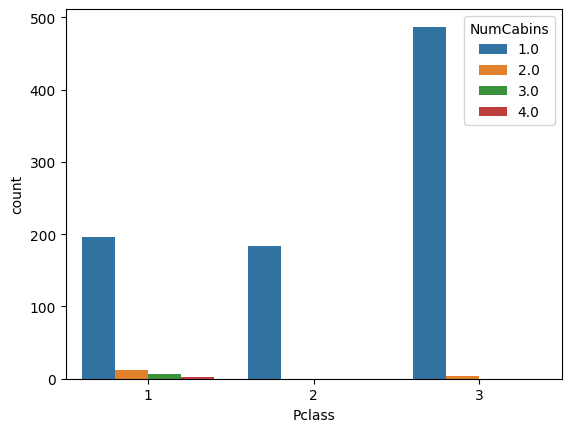

In [8]:
sns.countplot(data=df_eda, x="Pclass", hue="NumCabins")

# Test (Hold-Out) / Train Split

In [9]:
df = df_raw.copy()

feature_col_names = df.columns.drop('Survived')
target = df.loc[:, 'Survived']
features_all = df.loc[:, feature_col_names]

X_train, X_hold, y_train, y_hold = train_test_split(
    features_all,
    target,
    random_state=1,
    shuffle=True,
    #stratify=target,       # Dataset seems imbalanced and requires stratification
    test_size=0.20,        
)

display(f'X_train Shape: {X_train.shape}   y_train Shape: {y_train.shape}')
display(f'X_hold Shape: {X_hold.shape}   y_hold Shape: {y_hold.shape}')

'X_train Shape: (712, 11)   y_train Shape: (712,)'

'X_hold Shape: (179, 11)   y_hold Shape: (179,)'

In [10]:
display(X_train.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
301,302,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q
309,310,1,"Francatelli, Miss. Laura Mabel",female,30.0,0,0,PC 17485,56.9292,E36,C
516,517,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.5000,F33,S
120,121,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5000,NaN,S
570,571,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S


# Pipeline Feature Creation & Engineering

In [11]:
class SibSpParchTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X = X.copy()  
        X['GroupSize'] = X['SibSp'] + X['Parch']
        return X

    
class CabinTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Cab_Missing'] = np.where(X['Cabin'].isna(), 1, 0)
        X['Deck'] = X['Cabin'].str.extract('([A-Za-z])', expand=False)
        X['NumCabins'] = X['Cabin'].str.count(' ').add(1)
        X['NumCabins'] = X['NumCabins'].fillna(X['NumCabins'].mode()[0]).astype(float)
        X['FirstCabNum'] = X['Cabin'].str.extract('(\d+)', expand=False).astype(float)

        return X

    
class TicketTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ticketprefix_mapping=None):
        if ticketprefix_mapping is None:
            ticketprefix_mapping = {}
        self.ticketprefix_mapping = ticketprefix_mapping

    def fit(self, X, y=None):
        # Preparing ticket count mapping for TicketGroupSize
        self.ticket_counts_ = X['Ticket'].value_counts()
        return self

    def transform(self, X):
        X = X.copy()  # Work on a copy
        X['TicketPrefix'] = X['Ticket'].str.extract('([A-Za-z./]*[A-Za-z])', expand=False).str.replace('\.', '').str.upper()
        X['TicketNum'] = X['Ticket'].str.extract('(\d+)$')
        X['TicketGroupSize'] = X['Ticket'].map(self.ticket_counts_).astype(float)
        X['TicketNumDigits'] = X['TicketNum'].str.len()
        
        # Apply mappings and fill missing values
        X['TicketPrefix'] = X['TicketPrefix'].map(self.ticketprefix_mapping).fillna(X['TicketPrefix']).fillna('No_Prefix')
        X['TicketNumDigits'] = X['TicketNumDigits'].fillna(0).astype(float)
        X['TicketNum'] = X['TicketNum'].fillna(0).astype(float)
        return X

    
class NameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, title_map=None):
        if title_map is None:
            title_map = {}
        self.title_map = title_map

    def fit(self, X, y=None):
        # Preparing last name counts for LastNameRepeat
        self.last_name_counts_ = X['Name'].str.extract('^([^,]+),', expand=False).value_counts()
        return self

    def transform(self, X):
        X = X.copy()  # Work on a copy
        X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        X['LastName'] = X['Name'].str.extract('^([^,]+),', expand=False)
        X['LastNameRepeat'] = X['LastName'].map(self.last_name_counts_).astype(float)
        
        # Apply title mappings and fill missing values
        X['Title'] = X['Title'].map(self.title_map).fillna(X['Title'])
        return X


class FareTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=10, strategy='quantile'):
        self.n_bins = n_bins
        self.strategy = strategy
    
    def fit(self, X, y=None):
        self.discretizer_ = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy=self.strategy)
        self.discretizer_.fit(X[['Fare']])
        return self

    def transform(self, X):
        X = X.copy()  # Work on a copy
        X['FareQcut'] = self.discretizer_.transform(X[['Fare']])
        return X

    
class EmbarkedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')

    def fit(self, X, y=None):
        # Fit the imputer on the Embarked column
        self.imputer.fit(X[['Embarked']])
        return self

    def transform(self, X):
        X = X.copy()  
        X['Embarked'] = self.imputer.transform(X[['Embarked']])
        return X

In [12]:
class GroupRarePrefixesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, cutoff=5):
        self.column = column 
        self.cutoff = cutoff  
    
    def fit(self, X, y=None):
        value_counts = X[self.column].value_counts()
        self.to_group_ = value_counts[value_counts < self.cutoff].index
        return self
    
    def transform(self, X):
        X = X.copy()  
        X[self.column] = X[self.column].where(~X[self.column].isin(self.to_group_), other='OTHER')
        return X

    
class CbAgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initializing with default hyperparameters
        # Adjust any CatBoost hyperparameters as needed
        self.model = CatBoostRegressor(iterations=100,
                                       learning_rate=0.05,
                                       depth=6,
                                       cat_features=['name__Title', 'remainder__Sex'],
                                       loss_function='MAE',
                                       random_seed=42,
                                       verbose=False)

    def fit(self, X, y=None):
        # Ensure that X is a pandas DataFrame
        if isinstance(X, pd.DataFrame):
            # Define the feature columns as they appear after the previous transformations
            feature_cols = ['remainder__Pclass', 
                            'fam__SibSp', 
                            'fam__Parch', 
                            'name__Title', 
                            'remainder__Sex']
            # Define the target column
            target_col = 'remainder__Age'
            
            # Training the model on non-missing age rows
            self.model.fit(X.loc[X[target_col].notnull(), feature_cols], 
                           X.loc[X[target_col].notnull(), target_col])
        return self

    def transform(self, X):
        # Check if model is fitted
        if not hasattr(self, 'model'):
            raise RuntimeError("You must train the classifier before predicting data!")
        
        # Make a copy of the DataFrame to avoid changing the original data
        X_transformed = X.copy()

        # Define the feature columns and target column again
        feature_cols = ['remainder__Pclass', 
                        'fam__SibSp', 
                        'fam__Parch', 
                        'name__Title', 
                        'remainder__Sex']
        target_col = 'remainder__Age'

        # Apply the model to impute missing values
        missing_mask = X_transformed[target_col].isnull()
        if missing_mask.any():
            imputed_values = self.model.predict(X_transformed.loc[missing_mask, feature_cols])
            X_transformed.loc[missing_mask, target_col] = imputed_values
        
        return X_transformed

# Create Pipeline for Logistic Classifier

In [13]:
# Create the initial preprocessing pipeline
pre = ColumnTransformer(
    transformers=[
        ('fam', SibSpParchTransformer(), ['SibSp', 'Parch']),
        ('cab', CabinTransformer(), ['Cabin']),
        ('tick', TicketTransformer(), ['Ticket']),
        ('name', NameTransformer(), ['Name']),
        ('fare', FareTransformer(), ['Fare']),
        ('embrk', EmbarkedTransformer(), ['Embarked']),
    ],
    remainder='passthrough'  
)


# Create the imputation and tagging pipeline
imp = ColumnTransformer(
    transformers=[
        ('tikgrp', GroupRarePrefixesTransformer(column='tick__TicketPrefix', cutoff=5), make_column_selector(pattern='TicketPrefix')),
        ('impcb', CbAgeImputer(), ['remainder__Pclass', 'fam__SibSp', 'fam__Parch', 'name__Title', 'remainder__Sex', 'remainder__Age']),
        #('impcb', SimpleImputer(strategy='median'), ['remainder__Age']),
        ('imp1', SimpleImputer(strategy='constant', fill_value='Unknown'), ['cab__Deck', 'cab__Cabin']),
        #('imp1', SimpleImputer(strategy='most_frequent'), ['cab__Deck', 'cab__Cabin']),
        ('imp2', SimpleImputer(strategy='constant', fill_value=0), ['cab__FirstCabNum']),
        ('imp3', SimpleImputer(strategy='most_frequent'), ['cab__NumCabins']),
    ],
    remainder='passthrough'
)


# Create the column dropper pipeline which drops some original string columns with extreme cardinality
drop_logreg = ColumnTransformer(
    transformers=[
        ('drop1', 'drop', make_column_selector(pattern='remainder__name__Name')),
        ('drop2', 'drop', make_column_selector(pattern='imp1__cab__Cabin')),
        ('drop3', 'drop', make_column_selector(pattern='remainder__tick__Ticket')),
        ('drop4', 'drop', make_column_selector(pattern='remainder__name__LastName')),
        #('drop5', 'drop', make_column_selector(pattern='remainder__remainder__PassengerId')),
    ],
    remainder='passthrough'
)


# List of categorical columns to be transformed using ordinal encoder or one-hot encoder later on
cat_columns_logreg = ['Sex', 'Embarked', 'Title']
ord_columns_logreg = ['Deck', 'TicketPrefix']

# Create the Encoder pipeline
cat_enc_logreg = ColumnTransformer(
    transformers=[
        ('enc1', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=3000), make_column_selector(pattern=('|'.join(ord_columns_logreg)))),
        ('enc2', OneHotEncoder(handle_unknown='ignore', sparse_output=False), make_column_selector(pattern=('|'.join(cat_columns_logreg)))),
    ],
    remainder='passthrough'
)


# Create Feature Engineering 
poly_logreg = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Create Distribution Transformer
dist_logreg = QuantileTransformer(n_quantiles=50, output_distribution='normal')

# Create Scaler
scl_logreg = RobustScaler(unit_variance=False)

# Create Feature Selection
feats_logreg = SelectFromModel(estimator=LogisticRegression(max_iter=1000), threshold=None, max_features=None)
                   
# Create Dimensionality Reduction: PCA
pca_logreg = PCA(n_components=0.95, whiten=False)

# Create Classifier 
clf_logreg = LogisticRegression(penalty='l1', C=0.8, max_iter=700, solver='liblinear')

# Create The Main PreProcessing Pipeline
pipe_logreg = Pipeline([
    ('pre', pre),
    ('imp', imp),
    ('drop', drop_logreg),
    ('enc', cat_enc_logreg),
    ('poly', poly_logreg),
    ('dist', dist_logreg),
    ('scl', scl_logreg),
    ('feats', feats_logreg),
    ('pca', pca_logreg),
    ('clf', clf_logreg)
])

# Grid options for 'poly' step
poly_options_logreg = [
    PolynomialFeatures(degree=1, interaction_only=True, include_bias=False),
    #PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    #None  
]

# Grid options for 'dist' step
dist_options_logreg = [
    QuantileTransformer(n_quantiles=50, output_distribution='normal'),
    #QuantileTransformer(n_quantiles=50, output_distribution='uniform'),
    #PowerTransformer(method='yeo-johnson', standardize=True),
    #None  
]

# Grid options for 'scl' step
scl_options_logreg = [
    RobustScaler(unit_variance=False),
    #StandardScaler(),
    #None  
]

# Grid options for 'feats' step
feats_options_logreg = [
    SelectFromModel(estimator=LogisticRegression(max_iter=1000), threshold=None, max_features=None),
    #SelectFromModel(estimator=KNeighborsClassifier(n_neighbors=5), threshold=None, max_features=None),
    #SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0), threshold=None, max_features=None),  
    #SelectKBest(score_func=f_classif, k=14),
    #VarianceThreshold(),
    #None 
]

# Grid options for 'pca' step
pca_options_logreg = [
    #PCA(n_components=0.95, whiten=False),
    #PCA(n_components=0.97, whiten=False),
    None 
]

# Grid options for 'clf' step 
clf_options_logreg = [
    LogisticRegression(penalty='l1', C=0.8, max_iter=700, solver='liblinear'),
    #LogisticRegression(penalty='l2', C=0.2, max_iter=700, solver='liblinear'),
    #LogisticRegression(penalty='l1', C=0.9, max_iter=700, solver='liblinear'),
]

# Create K-Nearest Neighbor Classifier 


In [14]:
# Create KNN model
clf_knn = KNeighborsClassifier(n_neighbors=9)

# Create pipeline structure for KNN which will borrow some steps from Logistic Regression due to similar pre-processsing and feature engineering requirements
pipe_knn = Pipeline([
    ('pre', pre),
    ('imp', imp),
    ('drop', drop_logreg),
    ('enc', cat_enc_logreg),
    ('poly', poly_logreg),
    ('dist', dist_logreg),
    ('scl', scl_logreg),
    ('feats', feats_logreg),
    ('pca', pca_logreg),
    ('clf', clf_knn)
])

# Grid options for 'poly' step
poly_options_knn = [
    PolynomialFeatures(degree=1, interaction_only=True, include_bias=False),
    #PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    #None  
]

# Grid options for 'dist' step
dist_options_knn = [
    QuantileTransformer(n_quantiles=50, output_distribution='normal'),
    #QuantileTransformer(n_quantiles=50, output_distribution='uniform'),
    #PowerTransformer(method='yeo-johnson', standardize=True),
    #None  
]

# Grid options for 'scl' step
scl_options_knn = [
    RobustScaler(unit_variance=False),
    #StandardScaler(),
    #None  
]

# Grid options for 'feats' step
feats_options_knn = [
    #SelectFromModel(estimator=LogisticRegression(max_iter=1000), threshold=None, max_features=None),
    #SelectFromModel(estimator=KNeighborsClassifier(n_neighbors=5), threshold=None, max_features=None),
    #SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0), threshold=None, max_features=None),  
    #SelectKBest(score_func=f_classif, k=14),
    VarianceThreshold(),
    #None 
]

# Grid options for 'pca' step
pca_options_knn = [
    #PCA(n_components=0.95, whiten=False),
    #PCA(n_components=0.97, whiten=False),
    None 
]

# Grid options for 'clf' step 
clf_options_knn = [
    KNeighborsClassifier(n_neighbors=9),
    #KNeighborsClassifier(n_neighbors=10),
]

# Create Naive Bayes Classifier

In [15]:
# Create GNB model
clf_gnb = GaussianNB()

# Create pipeline structure for KNN which will borrow some steps from Logistic Regression due to similar pre-processsing and feature engineering requirements
pipe_gnb = Pipeline([
    ('pre', pre),
    ('imp', imp),
    ('drop', drop_logreg),
    ('enc', cat_enc_logreg),
    ('poly', poly_logreg),
    ('dist', dist_logreg),
    ('scl', scl_logreg),
    ('feats', feats_logreg),
    ('pca', pca_logreg),
    ('clf', clf_gnb)
])

# Grid options for 'poly' step
poly_options_gnb = [
    PolynomialFeatures(degree=1, interaction_only=True, include_bias=False),
    #PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    #None  
]

# Grid options for 'dist' step
dist_options_gnb = [
    QuantileTransformer(n_quantiles=50, output_distribution='normal'),
    #QuantileTransformer(n_quantiles=50, output_distribution='uniform'),
    #PowerTransformer(method='yeo-johnson', standardize=True),
    #None  
]

# Grid options for 'scl' step
scl_options_gnb = [
    RobustScaler(unit_variance=False),
    #StandardScaler(),
    #None  
]

# Grid options for 'feats' step
feats_options_gnb = [
    #SelectFromModel(estimator=LogisticRegression(max_iter=1000), threshold=None, max_features=None),
    #SelectFromModel(estimator=KNeighborsClassifier(n_neighbors=5), threshold=None, max_features=None),
    #SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0), threshold=None, max_features=None),  
    #SelectKBest(score_func=f_classif, k=14),
    VarianceThreshold(),
    #None 
]

# Grid options for 'pca' step
pca_options_gnb = [
    #PCA(n_components=0.95, whiten=False),
    #PCA(n_components=0.97, whiten=False),
    None 
]

# Grid options for 'clf' step 
clf_options_gnb = [
    GaussianNB()
]

# Create SVC Classifier

In [16]:
# Create SVC model with initial hyperparameters
clf_svc = SVC(kernel='rbf', C=8, gamma='auto', probability=True, class_weight=None) 

# Create pipeline structure for KNN which will borrow some steps from Logistic Regression due to similar pre-processsing and feature engineering requirements
pipe_svc = Pipeline([
    ('pre', pre),
    ('imp', imp),
    ('drop', drop_logreg),
    ('enc', cat_enc_logreg),
    ('poly', poly_logreg),
    ('dist', dist_logreg),
    ('scl', scl_logreg),
    ('feats', feats_logreg),
    ('pca', pca_logreg),
    ('clf', clf_svc)
])

# Grid options for 'poly' step
poly_options_svc = [
    PolynomialFeatures(degree=1, interaction_only=True, include_bias=False),
    #PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    #None  
]

# Grid options for 'dist' step
dist_options_svc = [
    QuantileTransformer(n_quantiles=50, output_distribution='normal'),
    #QuantileTransformer(n_quantiles=50, output_distribution='uniform'),
    #PowerTransformer(method='yeo-johnson', standardize=True),
    #None  
]

# Grid options for 'scl' step
scl_options_svc = [
    RobustScaler(unit_variance=False),
    #StandardScaler(),
    #None  
]

# Grid options for 'feats' step
feats_options_svc = [
    #SelectFromModel(estimator=LogisticRegression(max_iter=1000), threshold=None, max_features=None),
    #SelectFromModel(estimator=KNeighborsClassifier(n_neighbors=5), threshold=None, max_features=None),
    #SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0), threshold=None, max_features=None),  
    #SelectKBest(score_func=f_classif, k=14),
    VarianceThreshold(),
    #None 
]

# Grid options for 'pca' step
pca_options_svc = [
    #PCA(n_components=0.95, whiten=False),
    #PCA(n_components=0.97, whiten=False),
    None 
]

# Grid options for 'clf' step 
clf_options_svc = [
    SVC(kernel='rbf', C=8, gamma='auto', probability=True, class_weight=None),
]

# Create SGD Classifier

In [17]:
# Create SGD model with initial hyperparameters
clf_sgd = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.07, l1_ratio=0.10, max_iter=1000, random_state=0)

# Create pipeline structure for KNN which will borrow some steps from Logistic Regression due to similar pre-processsing and feature engineering requirements
pipe_sgd = Pipeline([
    ('pre', pre),
    ('imp', imp),
    ('drop', drop_logreg),
    ('enc', cat_enc_logreg),
    ('poly', poly_logreg),
    ('dist', dist_logreg),
    ('scl', scl_logreg),
    ('feats', feats_logreg),
    ('pca', pca_logreg),
    ('clf', clf_sgd)
])

# Grid options for 'poly' step
poly_options_sgd = [
    PolynomialFeatures(degree=1, interaction_only=True, include_bias=False),
    #PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    #None  
]

# Grid options for 'dist' step
dist_options_sgd = [
    QuantileTransformer(n_quantiles=50, output_distribution='normal'),
    #QuantileTransformer(n_quantiles=50, output_distribution='uniform'),
    #PowerTransformer(method='yeo-johnson', standardize=True),
    #None  
]

# Grid options for 'scl' step
scl_options_sgd = [
    RobustScaler(unit_variance=False),
    #StandardScaler(),
    #None  
]

# Grid options for 'feats' step
feats_options_sgd = [
    #SelectFromModel(estimator=LogisticRegression(max_iter=1000), threshold=None, max_features=None),
    #SelectFromModel(estimator=KNeighborsClassifier(n_neighbors=5), threshold=None, max_features=None),
    #SelectFromModel(estimator=RandomForestClassifier(n_estimators=200, max_depth=6, random_state=0), threshold=None, max_features=None),  
    #SelectKBest(score_func=f_classif, k=14),
    VarianceThreshold(),
    #None 
]

# Grid options for 'pca' step
pca_options_sgd = [
    #PCA(n_components=0.95, whiten=False),
    #PCA(n_components=0.97, whiten=False),
    None 
]

# Grid options for 'clf' step 
clf_options_sgd = [
    SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.07, l1_ratio=0.10, max_iter=1000, random_state=0),
    #SGDClassifier(loss='modified_huber', penalty='l2', alpha=0.0001, l1_ratio=0.15, max_iter=1000),
    
]

# Create Random Forest Classifier

In [18]:
# Create Classifier
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5)

# Create pipeline 
pipe_rf = Pipeline([
    ('pre', pre),
    ('imp', imp),
    ('drop', drop_logreg),
    ('enc', cat_enc_logreg),
    ('poly', poly_logreg),
    ('dist', dist_logreg),
    ('scl', scl_logreg),
    ('feats', feats_logreg),
    ('pca', pca_logreg),
    ('clf', clf_rf)
])

# Grid options for 'poly' step
poly_options_rf = [
    PolynomialFeatures(degree=1, interaction_only=True, include_bias=False),
    #PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    #None  
]

# Grid options for 'dist' step
dist_options_rf = [
    QuantileTransformer(n_quantiles=50, output_distribution='normal'),
    #QuantileTransformer(n_quantiles=50, output_distribution='uniform'),
    #PowerTransformer(method='yeo-johnson', standardize=True),
    #None  
]

# Grid options for 'scl' step
scl_options_rf = [
    RobustScaler(unit_variance=False),
    #StandardScaler(),
    #None  
]

# Grid options for 'feats' step
feats_options_rf = [
    #SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, max_depth=4), threshold=None, max_features=None),  
    #SelectFromModel(estimator=LogisticRegression(max_iter=1000), threshold=None, max_features=None),
    #SelectKBest(score_func=f_classif, k=14),
    VarianceThreshold(),
    #None 
]

# Grid options for 'pca' step
pca_options_rf = [
    #PCA(n_components=0.95, whiten=False),
    #PCA(n_components=0.97, whiten=False),
    None 
]

# Grid options for 'clf' step 
clf_options_rf = [
    RandomForestClassifier(n_estimators=100, max_depth=5),
]

# Create XGBoost Classifier

In [19]:
## Create Classifier
clf_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.06,max_depth=3,gamma=0.01,subsample=1)

# Create pipeline 
pipe_xgb = Pipeline([
    ('pre', pre),
    ('imp', imp),
    ('drop', drop_logreg),
    ('enc', cat_enc_logreg),
    ('poly', poly_logreg),
    ('dist', dist_logreg),
    ('scl', scl_logreg),
    ('feats', feats_logreg),
    ('pca', pca_logreg),
    ('clf', clf_xgb)
])

# Grid options for 'poly' step
poly_options_xgb = [
    PolynomialFeatures(degree=1, interaction_only=True, include_bias=False),
    #PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    #None  
]

# Grid options for 'dist' step
dist_options_xgb = [
    QuantileTransformer(n_quantiles=50, output_distribution='normal'),
    #QuantileTransformer(n_quantiles=50, output_distribution='uniform'),
    #PowerTransformer(method='yeo-johnson', standardize=True),
    #None  
]

# Grid options for 'scl' step
scl_options_xgb = [
    RobustScaler(unit_variance=False),
    #StandardScaler(),
    #None  
]

# Grid options for 'feats' step
feats_options_xgb = [
    SelectFromModel(estimator=xgb.XGBClassifier(n_estimators=200, learning_rate=0.05,max_depth=3,gamma=0,subsample=1), threshold=None, max_features=None),  
    #SelectFromModel(estimator=LogisticRegression(max_iter=1000), threshold=None, max_features=None),
    #SelectKBest(score_func=f_classif, k=14),
    #VarianceThreshold(),
    #None 
]

# Grid options for 'pca' step
pca_options_xgb = [
    #PCA(n_components=0.95, whiten=False),
    #PCA(n_components=0.97, whiten=False),
    None 
]

# Grid options for 'clf' step 
clf_options_xgb = [
    xgb.XGBClassifier(n_estimators=100, learning_rate=0.06,max_depth=3,gamma=0.01,subsample=1),
    #xgb.XGBClassifier()
]

# Create Light GBM Classifier

In [20]:
## Create Classifier
clf_lgb = lgb.LGBMClassifier(n_estimators=300, num_leaves=31, max_depth=3, learning_rate=0.04)

# Create pipeline 
pipe_lgb = Pipeline([
    ('pre', pre),
    ('imp', imp),
    ('drop', drop_logreg),
    ('enc', cat_enc_logreg),
    ('poly', poly_logreg),
    ('dist', dist_logreg),
    ('scl', scl_logreg),
    ('feats', feats_logreg),
    ('pca', pca_logreg),
    ('clf', clf_lgb)
])

# Grid options for 'poly' step
poly_options_lgb = [
    PolynomialFeatures(degree=1, interaction_only=True, include_bias=False),
    #PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    #None  
]

# Grid options for 'dist' step
dist_options_lgb = [
    QuantileTransformer(n_quantiles=50, output_distribution='normal'),
    #QuantileTransformer(n_quantiles=50, output_distribution='uniform'),
    #PowerTransformer(method='yeo-johnson', standardize=True),
    #None  
]

# Grid options for 'scl' step
scl_options_lgb = [
    RobustScaler(unit_variance=False),
    #StandardScaler(),
    #None  
]

# Grid options for 'feats' step
feats_options_lgb = [
    #SelectFromModel(estimator=lgb.LGBMClassifier(n_estimators=200, num_leaves=31, max_depth=4, learning_rate=0.03), threshold=None, max_features=None),  
    #SelectFromModel(estimator=LogisticRegression(max_iter=1000), threshold=None, max_features=None),
    #SelectKBest(score_func=f_classif, k=14),
    VarianceThreshold(),
    #None 
]

# Grid options for 'pca' step
pca_options_lgb = [
    #PCA(n_components=0.95, whiten=False),
    #PCA(n_components=0.97, whiten=False),
    None 
]

# Grid options for 'clf' step 
clf_options_lgb = [
    lgb.LGBMClassifier(n_estimators=300, num_leaves=31, max_depth=3, learning_rate=0.04),
]

# Voting Classifier Ensemble

In [21]:
# Create voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', pipe_logreg), 
        ('knn', pipe_knn), 
        ('gnb', pipe_gnb),
        ('svc', pipe_svc),
        ('sgd', pipe_sgd),
        ('rf', pipe_rf),
        ('xgb', pipe_xgb),
        ('lgb', pipe_lgb),
    ], voting='soft', verbose=False, flatten_transform=True)  

param_grid = {
    # Voting Classifier Parameters
    'weights': [
        #[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 3, 1, 3, 3, 3],
        #[0, 0, 0, 0, 0, 0, 0, 0],
        #[8, 8, 7, 8, 7, 8, 7, 8], 
    ],
    # Logistic Regression Pipeline Options
    'logreg__poly': poly_options_logreg,
    'logreg__dist': dist_options_logreg,
    'logreg__scl': scl_options_logreg,
    'logreg__feats': feats_options_logreg,
    'logreg__pca': pca_options_logreg,
    'logreg__clf': clf_options_logreg,
    
    # KNN Pipeline Options
    'knn__poly': poly_options_knn,
    'knn__dist': dist_options_knn,
    'knn__scl': scl_options_knn,
    'knn__feats': feats_options_knn,
    'knn__pca': pca_options_knn,
    'knn__clf': clf_options_knn,
    
    # GNB Pipeline Options
    'gnb__poly': poly_options_knn,
    'gnb__dist': dist_options_knn,
    'gnb__scl': scl_options_knn,
    'gnb__feats': feats_options_knn,
    'gnb__pca': pca_options_knn,
    'gnb__clf': clf_options_knn,
    
    # SVC Pipeline Options
    'svc__poly': poly_options_svc,
    'svc__dist': dist_options_svc,
    'svc__scl': scl_options_svc,
    'svc__feats': feats_options_svc,
    'svc__pca': pca_options_svc,
    'svc__clf': clf_options_svc,
    
    # SGD Pipeline Options
    'sgd__poly': poly_options_sgd,
    'sgd__dist': dist_options_sgd,
    'sgd__scl': scl_options_sgd,
    'sgd__feats': feats_options_sgd,
    'sgd__pca': pca_options_sgd,
    'sgd__clf': clf_options_sgd,

     # RF Pipeline Options
    'rf__poly': poly_options_rf,
    'rf__dist': dist_options_rf,
    'rf__scl': scl_options_rf,
    'rf__feats': feats_options_rf,
    'rf__pca': pca_options_rf,
    'rf__clf': clf_options_rf,
    
    # XGB Pipeline Options
    'xgb__poly': poly_options_xgb,
    'xgb__dist': dist_options_xgb,
    'xgb__scl': scl_options_xgb,
    'xgb__feats': feats_options_xgb,
    'xgb__pca': pca_options_xgb,
    'xgb__clf': clf_options_xgb,
    
    # LGB Pipeline Options
    'lgb__poly': poly_options_lgb,
    'lgb__dist': dist_options_lgb,
    'lgb__scl': scl_options_lgb,
    'lgb__feats': feats_options_lgb,
    'lgb__pca': pca_options_lgb,
    'lgb__clf': clf_options_lgb,
}

# Set up the GridSearchCV to find the best parameters (including weights)
stratified_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1, scoring='accuracy', return_train_score=True, verbose=False)

# Execute grid search
grid_search.fit(X_train, y_train)

# Print grid search key results 
print("Best weights: ", grid_search.best_params_['weights'])
print("Best parameters: ", grid_search.best_params_)
print("Mean test accuracy scores for each parameter combination: ", grid_search.cv_results_['mean_test_score'])
print("Mean training accuracy scores for each parameter combination: ", grid_search.cv_results_['mean_train_score'])
print("Best cross-validation accuracy: ", grid_search.best_score_)


# Turn off warnings
warnings.filterwarnings('ignore')

Best weights:  [1, 0, 1, 3, 1, 3, 3, 3]
Best parameters:  {'gnb__clf': KNeighborsClassifier(n_neighbors=9), 'gnb__dist': QuantileTransformer(n_quantiles=50, output_distribution='normal'), 'gnb__feats': VarianceThreshold(), 'gnb__pca': None, 'gnb__poly': PolynomialFeatures(degree=1, include_bias=False, interaction_only=True), 'gnb__scl': RobustScaler(), 'knn__clf': KNeighborsClassifier(n_neighbors=9), 'knn__dist': QuantileTransformer(n_quantiles=50, output_distribution='normal'), 'knn__feats': VarianceThreshold(), 'knn__pca': None, 'knn__poly': PolynomialFeatures(degree=1, include_bias=False, interaction_only=True), 'knn__scl': RobustScaler(), 'lgb__clf': LGBMClassifier(learning_rate=0.04, max_depth=3, n_estimators=300), 'lgb__dist': QuantileTransformer(n_quantiles=50, output_distribution='normal'), 'lgb__feats': VarianceThreshold(), 'lgb__pca': None, 'lgb__poly': PolynomialFeatures(degree=1, include_bias=False, interaction_only=True), 'lgb__scl': RobustScaler(), 'logreg__clf': Logistic

# Report Metrics

Accuracy: 0.8100558659217877


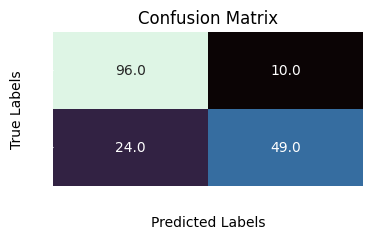

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       106
           1       0.83      0.67      0.74        73

    accuracy                           0.81       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

Best Estimator: VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('pre',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('fam',
                                                                                SibSpParchTransformer(),
                                                                                ['SibSp',
                                                                                 'Parch']),
                                                                            

In [22]:
# Use the best estimator from the grid search to make predictions on the test set
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_hold)

# Calculate accuracy
accuracy = accuracy_score(y_hold, y_pred)
print("Accuracy:", accuracy)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_hold, y_pred)
plt.figure(figsize=(4, 2))  # Size of the figure
ax = sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="mako", cbar=False)
plt.title('Confusion Matrix', color='black')
plt.xlabel('Predicted Labels', color='black')
plt.ylabel('True Labels', color='black')
plt.tick_params(colors='white', which='both')  # Tick colors
ax.xaxis.label.set_color('black')  # X label color
ax.yaxis.label.set_color('black')  # Y label color
plt.show()

# Generate the classification report
class_report = classification_report(y_hold, y_pred)
print("Classification Report:")
print(class_report)

# Display the best estimator from grid search that was used for predictions and classification reporting
print("Best Estimator:", best_estimator)

# Predict On New/Test Data & Generate CSV File

In [23]:
# Read test dataset from folders:
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

# No imputation was built in pipelines for Fare column as it had no NaN values in training dataset
df_test = (df_test
          .assign(
              Fare=lambda df_: df_.Fare.fillna(df_.Fare.mean()))
          )

display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

In [24]:
# Predict
predictions = grid_search.predict(df_test)

# Format results and print to CSV
df_pred = pd.DataFrame(predictions, columns=['Survived'])
df_pred.index = df_test.index
df_test_with_pred = (pd
                     .concat([df_test, df_pred], axis=1)
                     .loc[:, ['PassengerId', 'Survived']]
                    )
display(df_test_with_pred)

df_test_with_pred.to_csv('titanic_pred_9.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
